## Import packages

In [1]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict, GridSearchCV
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Set pd to show all columns
pd.set_option('display.max_columns', None)

In [28]:
data = pd.read_csv('HR_data.csv', index_col=0)
#Remove rows with missing values
data = data.dropna()


biometrics = ['HR_TD_Mean',  'HR_TD_std', 'HR_TD_Slope', 'TEMP_TD_Mean', 'TEMP_TD_std','TEMP_TD_Slope', 'EDA_TD_P_Mean',  'EDA_TD_P_std','EDA_TD_P_Slope', 'EDA_TD_T_Mean', 'EDA_TD_T_std','EDA_TD_T_Slope']

emotions = ['Frustrated', 'upset', 'hostile', 'alert',
       'ashamed', 'inspired', 'nervous', 'attentive', 'afraid', 'active',
       'determined']


phase1_data = data[data['Phase'] == "phase1"]
phase2_data = data[data['Phase'] == "phase2"]


# merge dataframes 
phase_data = pd.merge(phase1_data, phase2_data, on=["Individual","Round","Cohort"], suffixes=('_1', '_2'))





In [37]:
# create a delta column for each biometric
for biometric in biometrics:
    phase_data[biometric + "_delta"] = phase_data[biometric + "_2"] - phase_data[biometric + "_1"]

# create a delta column for each emotion
for emotion in emotions:
    phase_data[emotion + "_delta"] = phase_data[emotion + "_2"] - phase_data[emotion + "_1"]

delta_columns = [biometric + "_delta" for biometric in biometrics] + [emotion + "_delta" for emotion in emotions]


# only keep delta columns and "puzzler"
prepared_data = phase_data[delta_columns + ["Puzzler_1"]]

# rename "puzzler_1" to "puzzler"
prepared_data = prepared_data.rename(columns={"Puzzler_1": "Puzzler"})

## Data Setup

In [39]:
data = pd.read_csv('HR_data.csv', index_col=0)
#Remove rows with missing values
data = data.dropna()

puzzler = prepared_data[prepared_data['Puzzler'] == 1]
non_puzzler = prepared_data[prepared_data['Puzzler'] == 0]

biometrics = ['HR_TD_Mean_delta',  'HR_TD_std_delta', 'HR_TD_Slope_delta', 'TEMP_TD_Mean_delta', 'TEMP_TD_std_delta','TEMP_TD_Slope_delta', 'EDA_TD_P_Mean_delta',  'EDA_TD_P_std_delta','EDA_TD_P_Slope_delta', 'EDA_TD_T_Mean_delta', 'EDA_TD_T_std_delta','EDA_TD_T_Slope_delta']

emotions = ['Frustrated_delta', 'upset_delta', 'hostile_delta', 'alert_delta',
       'ashamed_delta', 'inspired_delta', 'nervous_delta', 'attentive_delta', 'afraid_delta', 'active_delta',
       'determined_delta']
neg_emotions = ['Frustrated_delta', 'upset_delta', 'hostile_delta', 'ashamed_delta', 'nervous_delta', 'afraid_delta']
pos_emotions = ['alert_delta', 'inspired_delta', 'attentive_delta', 'active_delta', 'determined_delta']
categories = ['Round', 'Phase', 'Individual', 'Puzzler', 'Cohort']

X_puzzler = puzzler[biometrics]
#y_puzzler sum of positive emotions and sum of negative emotions
y_puzzler = puzzler[emotions]
y_puzzler['Neg_emotions'] = y_puzzler[neg_emotions].sum(axis=1)
y_puzzler['Pos_emotions'] = y_puzzler[pos_emotions].sum(axis=1)


X_non_puzzler = non_puzzler[biometrics]
y_non_puzzler = non_puzzler[emotions]
y_non_puzzler['Neg_emotions'] = y_non_puzzler[neg_emotions].sum(axis=1)
y_non_puzzler['Pos_emotions'] = y_non_puzzler[pos_emotions].sum(axis=1)


/var/folders/_n/368hq85j0kj9gqq2gh6v174c0000gn/T/ipykernel_11845/3912287264.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_puzzler['Neg_emotions'] = y_puzzler[neg_emotions].sum(axis=1)
/var/folders/_n/368hq85j0kj9gqq2gh6v174c0000gn/T/ipykernel_11845/3912287264.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_puzzler['Pos_emotions'] = y_puzzler[pos_emotions].sum(axis=1)
/var/folders/_n/368hq85j0kj9gqq2gh6v174c0000gn/T/ipykernel_11845/3912287264.py:26: SettingWithCopyWarning: 
A value is trying 

## PLS

### PLS for positive emotions

In [40]:
# Positive emotions
# Puzzlers 

# Define PLS object
pls = PLSRegression()

#normalize data OBS: Måske ikke nødvendigt
X_puzzler = (X_puzzler - X_puzzler.mean()) / X_puzzler.std()

# parameters for cross-validation
n_comps = range(1, 12)
# Set up GridSearchCV
param_grid = {'n_components': n_comps}
grid = GridSearchCV(pls, param_grid, cv=10, n_jobs=-1, verbose=1, scoring=['neg_mean_squared_error', 'explained_variance'], refit='explained_variance')

# Fit the grid search model
search_puz_pos = grid.fit(X_puzzler, y_puzzler[['Pos_emotions']])
coef_puz_pos =grid.best_estimator_.coef_

# Non-puzzlers
# Define PLS object
pls = PLSRegression()

#normalize data OBS: Måske ikke nødvendigt
X_non_puzzler = (X_non_puzzler - X_non_puzzler.mean()) / X_non_puzzler.std()

# parameters for cross-validation
n_comps = range(1, 12)
# Set up GridSearchCV
param_grid = {'n_components': n_comps}
grid = GridSearchCV(pls, param_grid, cv=10, n_jobs=-1, verbose=1, scoring=['neg_mean_squared_error', 'explained_variance'], refit='explained_variance')

# Fit the grid search model
search_non_pos = grid.fit(X_non_puzzler, y_non_puzzler[['Pos_emotions']])
coef_non_pos =grid.best_estimator_.coef_


Fitting 10 folds for each of 11 candidates, totalling 110 fits
Fitting 10 folds for each of 11 candidates, totalling 110 fits


/Users/ap/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
/Users/ap/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


### PLS for negative emotions

In [41]:
# Negative emotions
# Puzzlers 

# Define PLS object
pls = PLSRegression()

#normalize data OBS: Måske ikke nødvendigt
X_puzzler = (X_puzzler - X_puzzler.mean()) / X_puzzler.std()

# parameters for cross-validation
n_comps = range(1, 12)
# Set up GridSearchCV
param_grid = {'n_components': n_comps}
grid = GridSearchCV(pls, param_grid, cv=10, n_jobs=-1, verbose=1, scoring=['neg_mean_squared_error', 'explained_variance'], refit='explained_variance')

# Fit the grid search model
search_puz_neg = grid.fit(X_puzzler, y_puzzler[['Neg_emotions']])
coef_puz_neg =grid.best_estimator_.coef_

# Non-puzzlers
# Define PLS object
pls = PLSRegression()

#normalize data OBS: Måske ikke nødvendigt
X_non_puzzler = (X_non_puzzler - X_non_puzzler.mean()) / X_non_puzzler.std()

# parameters for cross-validation
n_comps = range(1, 12)
# Set up GridSearchCV
param_grid = {'n_components': n_comps}
grid = GridSearchCV(pls, param_grid, cv=10, n_jobs=-1, verbose=1, scoring=['neg_mean_squared_error', 'explained_variance'], refit='explained_variance')

# Fit the grid search model
search_non_neg = grid.fit(X_non_puzzler, y_non_puzzler[['Neg_emotions']])
coef_non_neg =grid.best_estimator_.coef_


Fitting 10 folds for each of 11 candidates, totalling 110 fits
Fitting 10 folds for each of 11 candidates, totalling 110 fits


/Users/ap/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(
/Users/ap/opt/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


### Plotting

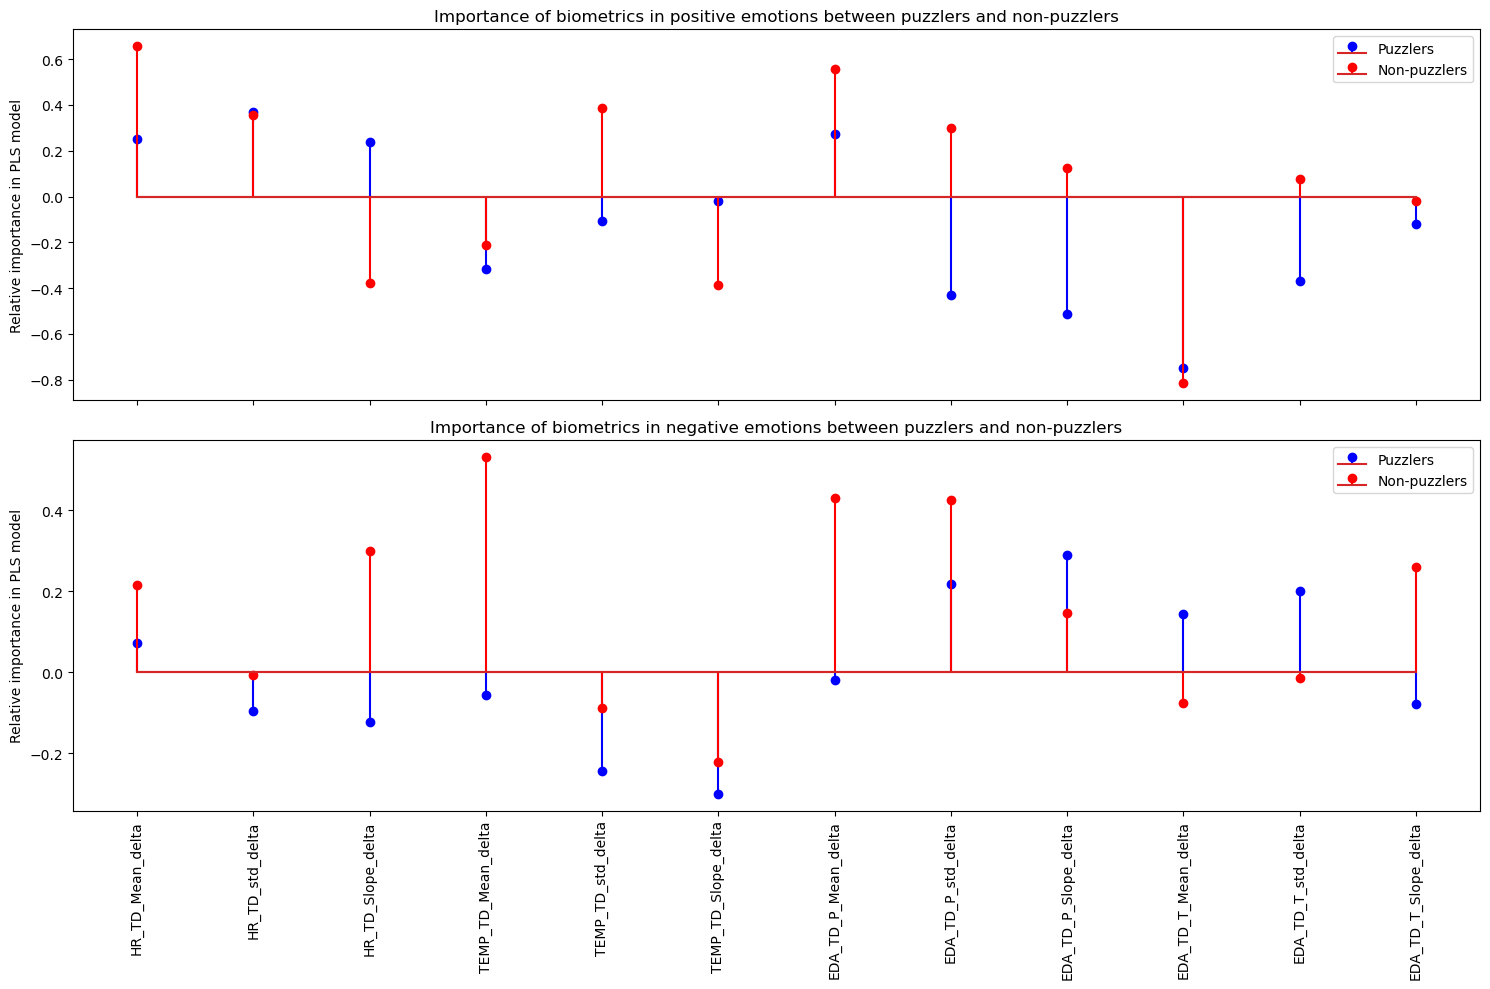

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 10))

# Plot first pair
ax1.set_ylabel('Relative importance in PLS model')
ax1.stem(range(1,13), coef_puz_pos.squeeze(), linefmt='b-', markerfmt='bo')
ax1.stem(range(1,13), coef_non_pos.squeeze(), linefmt='r-', markerfmt='ro')
ax1.legend(['Puzzlers', 'Non-puzzlers'])
ax1.set_title("Importance of biometrics in positive emotions between puzzlers and non-puzzlers")

# Plot second pair
ax2.set_ylabel('Relative importance in PLS model')
ax2.stem(range(1,13), coef_puz_neg.squeeze(), linefmt='b-', markerfmt='bo')
ax2.stem(range(1,13), coef_non_neg.squeeze(), linefmt='r-', markerfmt='ro')
ax2.legend(['Puzzlers', 'Non-puzzlers'])
ax2.set_title("Importance of biometrics in negative emotions between puzzlers and non-puzzlers")

# Set xticks to be the names of the variables
plt.xticks(range(1,13), X_puzzler.columns, rotation=90)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show plot
plt.show()


In [ ]:
# jacknife method 
